In [21]:
import pandas as pd
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.ensemble import RandomForestClassifier
import catboost as cat
from catboost import CatBoostClassifier
from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import log_loss, confusion_matrix, accuracy_score
import xgboost as xgb
import lightgbm as lgb
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

In [ ]:
#Create the log version of Item price
df['Item_Price_log'] = np.log1p(df['Item_Price'])
df['Item_Shelf_log'] = np.log1p(df['Item_Visibility'])

#Create some cross features
df['Item_Price_per_Item_Sugar_Content_mean'] = df['Item_Price']/df['Item_Sugar_Content'].map(df.groupby('Item_Sugar_Content').mean()['Item_Price'].to_dict())
df['Item_Price_per_Store_Location_Type_mean'] = df['Item_Price']/df['Store_Location_Type'].map(df.groupby('Store_Location_Type').mean()['Item_Price'].to_dict())
df['Item_Price_per_Store_Size_mean'] = df['Item_Price']/df['Store_Size'].map(df.groupby('Store_Size').mean()['Item_Price'].to_dict())
df['Item_Price_per_Item_Type_mean'] = df['Item_Price']/df['Item_Type'].map(df.groupby('Item_Type').mean()['Item_Price'].to_dict())
df['Item_Price_per_Store_Type_mean'] = df['Item_Price']/df['Store_Type'].map(df.groupby('Store_Type').mean()['Item_Price'].to_dict())
df['Item_Price_per_Item_Identifier_mean'] = df['Item_Price']/df['Item_ID'].map(df.groupby('Item_ID').mean()['Item_Price'].to_dict())
df['Item_Price_per_Store_Opening_year_mean'] = df['Item_Price']/df['Store_Start_Year'].map(df.groupby('Store_Start_Year').mean()['Item_Price'].to_dict())
df['Item_Price_per_Store_Identifier_mean'] = df['Item_Price']/df['Store_ID'].map(df.groupby('Store_ID').mean()['Item_Price'].to_dict())

df['cross_Price_weight'] = df['Item_Price'] * df['Item_Weight']
df['cross_Price_visibility'] = df['Item_Price'] * df['Item_Visibility']
df['cross_Price_visibility_weight'] = df['Item_Price'] * df['Item_Visibility'] * df['Item_Weight']

In [2]:
#importing files
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
sample = pd.read_csv('sample_submission.csv')

In [3]:
def fill_missing_values(data):
    
    '''
    Function to input missing values based on the column object type
    '''
    
    cols = list(data.columns)
    for col in cols:
        if data[col].dtype == 'int64' or data[col].dtype == 'float64':
        
            data[col] = data[col].fillna(data[col].mean())
        
        #elif data[col].dtype == 'O' or data[col].dtype == 'object':
        #    data[col] = data[col].fillna(data[col].mode()[0])
            
        else:
            data[col] = data[col].fillna(data[col].mode()[0])
            
    return data

In [4]:
def freq_encoding(traindata, testdata, *args):
    
    for _ in args:
        train_enc = (traindata.groupby(_).size()) / len(traindata)
        test_enc = (testdata.groupby(_).size()) / len(testdata)
        
        traindata[_] = traindata[_].apply(lambda x: train_enc[x])
        testdata[_] = testdata[_].apply(lambda x: test_enc[x])
    
    return traindata, testdata

In [5]:
def one_hot_encoding(traindata, testdata, *args):
    
    for ii in args:
        traindata = pd.get_dummies(traindata, prefix=[ii], columns=[ii])
        testdata = pd.get_dummies(testdata, prefix=[ii], columns=[ii])
        
    return traindata, testdata

In [6]:
def drop_columns(traindata, testdata, target, *args):
    
    labels = np.array(traindata[target])
    
    columns = []
    for _ in args:
        columns.append(_)
        
    traindata = traindata.drop(columns, axis=1)
    traindata = traindata.drop(target, axis=1)
    testdata = testdata.drop(columns, axis=1)
        
    return labels, traindata, testdata

In [7]:
def mean_encoding(traindata, testdata, *args):
    for _ in args:
        mean_encode = traindata.groupby(_)['CHURN'].mean()
        traindata[:, _ + '_mean_enc'] = traindata[_].map(mean_encode)
        
    for _ in args:
        mean_encode = testdata.groupby(_)['CHURN'].mean()
        testdata[:, _ + '_mean_enc'] = testdata[_].map(mean_encode)
        
    return traindata, testdata

def mean_encode1(traindata, testdata, *args):
    for _ in args:
        ce_TE = ce.TargetEncoder(cols=[_])
        ce_TE.fit(traindata[_],traindata.CHURN)
        ce_TE.transform(traindata[_])
        
    for _ in args:
        ce_TE = ce.TargetEncoder(cols=[_])
        ce_TE.fit(testdata[_],testdata.CHURN)
        ce_TE.transform(testdata[_])
        
    return traindata, testdata

In [ ]:
#!pip install category_encoders
import category_encoders as ce

In [ ]:
def generate_features(traindata, testdata, args):
    
    cols = list(args)
    for i in cols:
        for j in cols:
            traindata[i + '+' + j] = traindata[i] + traindata[j]
            traindata[i + '-' + j] = traindata[i] - traindata[j]
            traindata[i + '/' + j] = traindata[i] / traindata[j]
            traindata[i + '*' + j] = traindata[i] * traindata[j]
            
            traindata = traindata.drop([i + '+' + i])
            traindata = traindata.drop([i + '-' + i])
            traindata = traindata.drop([i + '/' + i])
            traindata = traindata.drop([i + '*' + i])
            
            testdata[i + '+' + j] = testdata[i] + testdata[j]
            testdata[i + '-' + j] = testdata[i] - testdata[j]
            testdata[i + '/' + j] = testdata[i] / testdata[j]
            testdata[i + '*' + j] = testdata[i] * testdata[j]
            
            testdata = testdata.drop([i + '+' + i])
            testdata = testdata.drop([i + '-' + i])
            testdata = testdata.drop([i + '/' + i])
            testdata = testdata.drop([i + '*' + i])
            
    return traindata, testdata

In [33]:
cols = ['ZONE1', 'ZONE2', 'TIGO', 'MRG']

labels, train1, test1 = drop_columns(df, test, 'CHURN', *cols)

In [34]:
one_hot_cols = ['REGION', 'TENURE']

train1, test1 = one_hot_encoding(train1, test1, *one_hot_cols)

In [10]:
train.isna().sum()

user_id                0
REGION            157520
TENURE                 0
MONTANT           140277
FREQUENCE_RECH    140277
REVENUE           134663
ARPU_SEGMENT      134663
FREQUENCE         134663
DATA_VOLUME       196854
ON_NET            145819
ORANGE            166317
TIGO              239386
ZONE1             368310
ZONE2             374487
MRG                    0
REGULARITY             0
TOP_PACK          167329
FREQ_TOP_PACK     167329
CHURN                  0
dtype: int64

In [12]:
train2 = train.copy()
test2 = test.copy()
train2 = train2.fillna(-999)
test2 = test2.fillna(-999)

In [43]:
train1 = train1.fillna(-999)
test1 = test1.fillna(-999)

In [62]:
train1 = fill_missing_values(train1)
test1 = fill_missing_values(test1)

In [36]:
freq_col = ['TOP_PACK']

train1, test1 = freq_encoding(train1, test1, *freq_col)

In [16]:
prob_df_region = train2.groupby(['REGION'])['CHURN'].mean()
prob_df_tenure = train2.groupby(['TENURE'])['CHURN'].mean()

#prob_df_region = pd.DataFrame(prob_df_region)
train1['churned_region'] = prob_df_region

In [18]:
train1['churned_region'].isna().sum()

400000

In [49]:
from sklearn.decomposition import PCA
pca =  PCA()
train_trans = pca.fit_transform(train1)
test_trans = pca.transform(test1)

train1 = pd.merge(pd.DataFrame(train1), pd.DataFrame(train_trans),left_index=True,right_index=True)
test1 = pd.merge(pd.DataFrame(test1), pd.DataFrame(test_trans),left_index=True,right_index=True)

In [50]:
#mean_encode_cols = ['REGION', 'TENURE']
#train1, test1 = mean_encode1(train, test, mean_encode_cols)

In [39]:
train.isna().sum()

user_id                0
REGION            157520
TENURE                 0
MONTANT           140277
FREQUENCE_RECH    140277
REVENUE           134663
ARPU_SEGMENT      134663
FREQUENCE         134663
DATA_VOLUME       196854
ON_NET            145819
ORANGE            166317
TIGO              239386
ZONE1             368310
ZONE2             374487
MRG                    0
REGULARITY             0
TOP_PACK          167329
FREQ_TOP_PACK     167329
CHURN                  0
dtype: int64

In [20]:
train2 = train.copy()
test2 = test.copy()

In [24]:
def mean_target(data, cols):
    kf = KFold(5)
    a = pd.DataFrame()
    for tr_ind, val_ind in kf.split(data):
        X_tr, X_val= data.iloc[tr_ind].copy(), data.iloc[val_ind].copy()
        for col in cols:
            means = X_val[col].map(X_tr.groupby(col).CHURN.mean())
            X_val[col + '_mean_target'] = means + 0.0001
        a = pd.concat((a, X_val))
    prior = CHURN.mean()
    a.fillna(prior, inplace=True)
    return a

In [27]:
CHURN = train.CHURN.copy()

train2 = mean_target(train2, ['TENURE', 'REGION'])

In [ ]:
train2 = train1[:ntrain].copy()
target = train.CHURN.copy()
train2.drop('CHURN', axis=1, inplace=True)

test = df2[ntrain:].copy()
test.drop('target', axis=1, inplace=True)
test = test.reset_index(drop=True)

In [49]:
train2

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,...,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN,TENURE_mean_target,REGION_mean_target
0,dcf68cc2fb515ccad7d8b9b3bd80ee2a4b270063,SAINT-LOUIS,K > 24 month,17000.00000,32.00000,18000.00000,6000.00000,34.00000,0.18711,97.00000,...,6.00000,0.18711,0.18711,NO,62,All-net 500F=2000F;5d,35.00000,0,0.183067,0.013421
1,71c44b5ba328db5c4192a80f7cf8f244d9350ed0,0.18711,K > 24 month,4300.00000,29.00000,4427.00000,1476.00000,37.00000,1764.00000,8.00000,...,0.00000,0.18711,2.00000,NO,40,"Data: 100 F=40MB,24H",22.00000,0,0.183067,0.447144
2,ce46411b1526c94f20a383b8cb188f8d27f82a0a,TAMBACOUNDA,K > 24 month,1500.00000,3.00000,1500.00000,500.00000,3.00000,0.18711,30.00000,...,0.18711,0.18711,0.18711,NO,32,All-net 500F=2000F;5d,3.00000,0,0.183067,0.015858
3,f467cdb6669818373c26c2bad44e01ba66f97d21,FATICK,K > 24 month,1500.00000,3.00000,2497.00000,832.00000,4.00000,0.00000,159.00000,...,19.00000,0.18711,0.18711,NO,18,On net 200F=Unlimited _call24H,3.00000,0,0.183067,0.016115
4,ec45e1a1888a32b5dcce0954cfec20c6e037db31,FATICK,K > 24 month,0.18711,0.18711,498.00000,166.00000,3.00000,1.00000,1.00000,...,0.18711,0.18711,0.18711,NO,50,0.18711,0.18711,0,0.183067,0.016115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,a892ad4ed0eda8dc721733200c47147763b183ec,TAMBACOUNDA,K > 24 month,700.00000,2.00000,704.00000,235.00000,3.00000,0.18711,12.00000,...,0.18711,0.18711,0.18711,NO,46,All-net 500F=2000F;5d,1.00000,0,0.183230,0.015522
399996,13daa3a651bf0192a413b339c4766aeafc6d1636,0.18711,K > 24 month,0.18711,0.18711,0.18711,0.18711,0.18711,0.18711,0.18711,...,0.18711,0.18711,0.18711,NO,14,0.18711,0.18711,0,0.183230,0.447009
399997,767f596aee426962f7d92f4de8d7b232cdc17568,0.18711,K > 24 month,700.00000,2.00000,699.00000,233.00000,5.00000,237.00000,1.00000,...,0.18711,0.18711,0.18711,NO,15,"Data: 100 F=40MB,24H",3.00000,0,0.183230,0.447009
399998,b831e4d3b59a1e294e9e0a2aab391bc12d50845c,0.18711,K > 24 month,0.18711,0.18711,9.00000,3.00000,1.00000,0.00000,0.18711,...,0.18711,0.18711,0.18711,NO,5,0.18711,0.18711,1,0.183230,0.447009


In [28]:
ntrain = train.shape[0]
ntest = test.shape[0]

train3 = train2[:ntrain].copy()
CHURN = train3.CHURN.copy()
train3.drop('CHURN', axis=1, inplace=True)

test3 = df2[ntrain:].copy()
test3.drop('CHURN', axis=1, inplace=True)
test3 = test3.reset_index(drop=True)

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,...,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN,TENURE_mean_target,REGION_mean_target
0,dcf68cc2fb515ccad7d8b9b3bd80ee2a4b270063,SAINT-LOUIS,K > 24 month,17000.00000,32.00000,18000.00000,6000.00000,34.00000,0.18711,97.00000,...,6.00000,0.18711,0.18711,NO,62,All-net 500F=2000F;5d,35.00000,0,0.183067,0.013421
1,71c44b5ba328db5c4192a80f7cf8f244d9350ed0,0.18711,K > 24 month,4300.00000,29.00000,4427.00000,1476.00000,37.00000,1764.00000,8.00000,...,0.00000,0.18711,2.00000,NO,40,"Data: 100 F=40MB,24H",22.00000,0,0.183067,0.447144
2,ce46411b1526c94f20a383b8cb188f8d27f82a0a,TAMBACOUNDA,K > 24 month,1500.00000,3.00000,1500.00000,500.00000,3.00000,0.18711,30.00000,...,0.18711,0.18711,0.18711,NO,32,All-net 500F=2000F;5d,3.00000,0,0.183067,0.015858
3,f467cdb6669818373c26c2bad44e01ba66f97d21,FATICK,K > 24 month,1500.00000,3.00000,2497.00000,832.00000,4.00000,0.00000,159.00000,...,19.00000,0.18711,0.18711,NO,18,On net 200F=Unlimited _call24H,3.00000,0,0.183067,0.016115
4,ec45e1a1888a32b5dcce0954cfec20c6e037db31,FATICK,K > 24 month,0.18711,0.18711,498.00000,166.00000,3.00000,1.00000,1.00000,...,0.18711,0.18711,0.18711,NO,50,0.18711,0.18711,0,0.183067,0.016115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,a892ad4ed0eda8dc721733200c47147763b183ec,TAMBACOUNDA,K > 24 month,700.00000,2.00000,704.00000,235.00000,3.00000,0.18711,12.00000,...,0.18711,0.18711,0.18711,NO,46,All-net 500F=2000F;5d,1.00000,0,0.183230,0.015522
399996,13daa3a651bf0192a413b339c4766aeafc6d1636,0.18711,K > 24 month,0.18711,0.18711,0.18711,0.18711,0.18711,0.18711,0.18711,...,0.18711,0.18711,0.18711,NO,14,0.18711,0.18711,0,0.183230,0.447009
399997,767f596aee426962f7d92f4de8d7b232cdc17568,0.18711,K > 24 month,700.00000,2.00000,699.00000,233.00000,5.00000,237.00000,1.00000,...,0.18711,0.18711,0.18711,NO,15,"Data: 100 F=40MB,24H",3.00000,0,0.183230,0.447009
399998,b831e4d3b59a1e294e9e0a2aab391bc12d50845c,0.18711,K > 24 month,0.18711,0.18711,9.00000,3.00000,1.00000,0.00000,0.18711,...,0.18711,0.18711,0.18711,NO,5,0.18711,0.18711,1,0.183230,0.447009


In [31]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
submission = pd.read_csv('sample_submission.csv')

ntrain = train.shape[0]
ntest = test.shape[0]
target = train.CHURN.copy()
df = pd.concat((train, test)).reset_index(drop=True)
df = df.drop('user_id', 1)

In [37]:
train1['REG*REV'] = train1['REGULARITY'] * train1['REVENUE']
train1['REG/REV'] = train1['REGULARITY'] / train1['REVENUE']
train1['LOG_REV'] = np.log(train1['REVENUE'])
train1['REG*MUT'] = train1['REGULARITY'] * train1['MONTANT']
train1['REG/MUT'] = train1['REGULARITY'] / train1['MONTANT']
train1['LOG_MUT'] = np.log(train1['MONTANT'])
train1['REG*NET'] = train1['REGULARITY'] * train1['ON_NET']
train1['REG/NET'] = train1['REGULARITY'] / train1['ON_NET']
train1['FREQ+FREQ'] = train1['FREQUENCE_RECH'] + train1['FREQUENCE']
train1['FREQ-FREQ'] = train1['FREQUENCE_RECH'] - train1['FREQUENCE']
train1['LOG_NET'] = np.log(train1['ON_NET'])
train1['REV+DAT'] = train1['REVENUE'] + train1['DATA_VOLUME']
train1['REV-DAT'] = train1['REVENUE'] - train1['DATA_VOLUME']
train1['REV-DAT'] = train1['REVENUE'] - train1['DATA_VOLUME']
train1['REV/DAT'] = train1['REVENUE'] / train1['DATA_VOLUME']
train1['REV-ARP'] = train1['REVENUE'] - train1['ARPU_SEGMENT']
train1['REV+ARP'] = train1['REVENUE'] + train1['ARPU_SEGMENT']
train1['REV*ARP'] = train1['REVENUE'] * train1['ARPU_SEGMENT']
train1['REV/ARP'] = train1['REVENUE'] / train1['ARPU_SEGMENT']
train1['REV*FREQ'] = train1['REVENUE'] * train1['FREQUENCE']
train1['REV/FREQ'] = train1['REVENUE'] / train1['FREQUENCE']
train1['LOG_DAT'] = np.log(train1['DATA_VOLUME'])
train1['LOG_ARP'] = np.log(train1['ARPU_SEGMENT'])

/home/olawale/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/olawale/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [38]:
test1['REG*REV'] = test1['REGULARITY'] * test1['REVENUE']
test1['REG/REV'] = test1['REGULARITY'] / test1['REVENUE']
test1['LOG_REV'] = np.log(test1['REVENUE'])
test1['REG*MUT'] = test1['REGULARITY'] * test1['MONTANT']
test1['REG/MUT'] = test1['REGULARITY'] / test1['MONTANT']
test1['LOG_MUT'] = np.log(test1['MONTANT'])
test1['REG*NET'] = test1['REGULARITY'] * test1['ON_NET']
test1['REG/NET'] = test1['REGULARITY'] / test1['ON_NET']
test1['FREQ+FREQ'] = test1['FREQUENCE_RECH'] + test1['FREQUENCE']
test1['FREQ-FREQ'] = test1['FREQUENCE_RECH'] - test1['FREQUENCE']
test1['LOG_NET'] = np.log(test1['ON_NET'])
test1['REV+DAT'] = test1['REVENUE'] + test1['DATA_VOLUME']
test1['REV-DAT'] = test1['REVENUE'] - test1['DATA_VOLUME']
test1['REV-DAT'] = test1['REVENUE'] - test1['DATA_VOLUME']
test1['REV/DAT'] = test1['REVENUE'] / test1['DATA_VOLUME']
test1['REV-ARP'] = test1['REVENUE'] - test1['ARPU_SEGMENT']
test1['REV+ARP'] = test1['REVENUE'] + test1['ARPU_SEGMENT']
test1['REV*ARP'] = test1['REVENUE'] * test1['ARPU_SEGMENT']
test1['REV/ARP'] = test1['REVENUE'] / test1['ARPU_SEGMENT']
test1['REV*FREQ'] = test1['REVENUE'] * test1['FREQUENCE']
test1['REV/FREQ'] = test1['REVENUE'] / test1['FREQUENCE']
test1['LOG_DAT'] = np.log(test1['DATA_VOLUME'])
test1['LOG_ARP'] = np.log(test1['ARPU_SEGMENT'])

In [18]:
train1.shape

,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,REGULARITY,FREQ_TOP_PACK,...,REV-DAT,REV/DAT,REV-ARP,REV+ARP,REV*ARP,REV/ARP,REV*FREQ,REV/FREQ,LOG_DAT,LOG_ARP
count,259723.000000,259723.000000,265337.000000,265337.000000,265337.000000,203146.000000,254181.000000,233683.000000,400000.000000,232671.000000,...,175914.000000,175914.000000,265337.000000,265337.000000,2.653370e+05,265337.000000,2.653370e+05,265337.000000,203146.000000,265337.000000
mean,5522.971346,11.503733,5505.487757,1835.167658,13.951835,3369.763441,275.917586,95.532927,28.046502,9.254209,...,2266.354713,220.961917,3670.320099,7340.655416,2.726744e+07,2.990374,1.602017e+05,414.767801,4.598087,6.692516
std,7099.640630,13.275514,7175.802367,2391.929290,14.679943,12281.867504,873.593034,204.733272,22.282773,12.305563,...,12543.110997,1558.641572,4783.873101,9567.731645,1.178113e+08,0.174241,4.010264e+05,553.931184,3.749832,1.555292
min,20.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,-853876.000000,0.000000,1.000000,1.000000,0.000000e+00,0.000000,1.000000e+00,1.000000,0.000000,0.000000
25%,1000.000000,2.000000,1000.000000,333.000000,3.000000,0.000000,5.000000,7.000000,6.000000,2.000000,...,46.000000,0.000000,667.000000,1333.000000,3.330000e+05,2.999492,3.204000e+03,216.769231,0.000000,5.808142
50%,3000.000000,6.000000,3000.000000,1000.000000,9.000000,267.000000,27.000000,29.000000,24.000000,5.000000,...,1299.000000,0.993802,2000.000000,4000.000000,3.000000e+06,3.000000,2.640000e+04,359.285714,5.587249,6.907755
75%,7300.000000,15.000000,7340.000000,2447.000000,19.000000,2925.000000,155.000000,99.000000,51.000000,12.000000,...,4550.000000,4.963857,4893.000000,9787.000000,1.796098e+07,3.000405,1.359450e+05,500.000000,7.981050,7.802618
max,226550.000000,133.000000,233413.000000,77804.000000,91.000000,934576.000000,45011.000000,6788.000000,62.000000,629.000000,...,225540.000000,159640.000000,155609.000000,311217.000000,1.816047e+10,4.000000,2.077376e+07,115337.000000,13.747848,11.261948


In [39]:
def process(traindata, testdata):
    
    cols = list(traindata.columns)
    for _ in cols:
        traindata[_] = np.where(traindata[_] == np.inf, 0, traindata[_])
        testdata[_] = np.where(testdata[_] == np.inf, 0, testdata[_])
        traindata[_] = np.where(traindata[_] == np.nan, 0, traindata[_])
        testdata[_] = np.where(testdata[_] == np.nan, 0, testdata[_])
        traindata[_] = np.where(traindata[_] == -np.inf, 0, traindata[_])
        testdata[_] = np.where(testdata[_] == -np.inf, 0, testdata[_])
        
    return traindata, testdata

In [40]:
train1, test1 = process(train1, test1)

In [42]:
train1.isna().sum()

MONTANT                      0
FREQUENCE_RECH               0
REVENUE                      0
ARPU_SEGMENT                 0
FREQUENCE                    0
DATA_VOLUME                  0
ON_NET                       0
ORANGE                       0
REGULARITY                   0
TOP_PACK                     0
FREQ_TOP_PACK                0
REGION_DAKAR                 0
REGION_DIOURBEL              0
REGION_FATICK                0
REGION_KAFFRINE              0
REGION_KAOLACK               0
REGION_KEDOUGOU              0
REGION_KOLDA                 0
REGION_LOUGA                 0
REGION_MATAM                 0
REGION_SAINT-LOUIS           0
REGION_SEDHIOU               0
REGION_TAMBACOUNDA           0
REGION_THIES                 0
REGION_ZIGUINCHOR            0
TENURE_D 3-6 month           0
TENURE_E 6-9 month           0
TENURE_F 9-12 month          0
TENURE_G 12-15 month         0
TENURE_H 15-18 month         0
TENURE_I 18-21 month         0
TENURE_J 21-24 month         0
TENURE_K

In [50]:
def feature_interact(train, cols):
    for i in cols:
        for j in cols: train[i + '/' + j] = train[i] / train[j]

    for i in cols:
        for j in cols: train[i + '+' + j] = train[i] + train[j]

    for i in cols:
        for j in cols: train[i + '-' + j] = train[i] - train[j]

    for i in cols:
        for j in cols: train[i + '*' + j] = train[i] * train[j]
            
    if i in list(train.columns):
        if train[i].min() == 0 and train[i].max() == 0:
            train = train.drop(i, axis=1)
            
    return train


In [51]:
feature_cols = ['REVENUE', 'ARPU_SEGMENT', 'FREQUENCE', 'REGULARITY']

train1 = feature_interact(train1, feature_cols)
test1 = feature_interact(test1, feature_cols)

In [53]:
train1.describe()

,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,REGULARITY,TOP_PACK,...,FREQ_TOP_PACK*FREQUENCE_RECH,FREQ_TOP_PACK*REVENUE,FREQ_TOP_PACK*ARPU_SEGMENT,FREQ_TOP_PACK*FREQUENCE,FREQ_TOP_PACK*DATA_VOLUME,FREQ_TOP_PACK*ON_NET,FREQ_TOP_PACK*ORANGE,FREQ_TOP_PACK*REGULARITY,FREQ_TOP_PACK*TOP_PACK,FREQ_TOP_PACK*FREQ_TOP_PACK
count,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,400000.000000,...,400000.000000,4.000000e+05,4.000000e+05,400000.000000,4.000000e+05,4.000000e+05,4.000000e+05,400000.000000,400000.000000,400000.000000
mean,3235.764910,-342.872347,3315.703170,881.023860,-327.065997,1219.742045,-188.850433,-359.565655,28.046502,0.210899,...,346610.016187,3.368942e+05,3.362632e+05,335766.023155,3.041744e+05,3.167492e+05,3.576385e+05,-4074.945715,-174.489506,417624.169632
std,6512.606182,482.318318,6603.421492,2364.108984,478.837134,9021.014027,928.163148,561.688367,22.282773,0.180485,...,475207.162700,9.824639e+05,5.520954e+05,471744.415197,2.258445e+06,4.642740e+05,4.790895e+05,10071.367158,206.426297,492182.376945
min,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,1.000000,0.000003,...,-85914.000000,-1.152217e+08,-3.840755e+07,-88911.000000,-7.195887e+08,-7.433559e+06,-3.536460e+06,-61938.000000,-417.904178,1.000000
25%,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,6.000000,0.031780,...,9.000000,4.000000e+03,1.334000e+03,12.000000,0.000000e+00,1.100000e+01,2.400000e+01,-2997.000000,-417.904178,16.000000
50%,1000.000000,2.000000,1000.000000,333.000000,3.000000,0.000000,3.000000,3.000000,24.000000,0.146687,...,170.000000,7.197150e+04,2.399000e+04,192.000000,4.124000e+03,7.260000e+02,8.960000e+02,24.000000,0.028012,361.000000
75%,4600.000000,10.000000,4698.000000,1566.000000,13.000000,301.000000,55.000000,41.000000,51.000000,0.418322,...,998001.000000,9.980010e+05,9.980010e+05,998001.000000,9.980010e+05,9.980010e+05,9.980010e+05,255.000000,0.283870,998001.000000
max,226550.000000,133.000000,233413.000000,77804.000000,91.000000,934576.000000,45011.000000,6788.000000,62.000000,0.418322,...,998001.000000,3.991362e+07,1.330448e+07,998001.000000,2.557974e+07,4.821150e+06,9.980010e+05,34595.000000,37.111937,998001.000000


In [52]:
x_train, x_test, y_train, y_test = ms.train_test_split(train1, train.CHURN, test_size=0.2,
                                                       random_state=42)

In [53]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(320000, 88) (320000,)
(80000, 88) (80000,)


In [58]:
x_test1, x_test2,y_test1, y_test2 = ms.train_test_split(x_test, y_test, test_size=0.5,
                                                         random_state=42)

In [64]:
#using StandardScaler function to scale the numeric features 

scaler = preprocessing.StandardScaler().fit(train1)
train1 = scaler.transform(train1)
train1

array([[ 2.11347837,  0.77723114,  2.22374343, ...,  0.78041646,
         0.07425879,  0.54524581],
       [ 0.16341176,  0.77101117,  0.16829127, ...,  0.78041646,
         0.04198721, -0.54479474],
       [-0.26652419,  0.7171048 , -0.27496434, ...,  0.71679022,
         0.08501599,  0.03260482],
       ...,
       [-0.38936303,  0.71503147, -0.39626525, ...,  0.71785066,
         0.0688802 , -1.45318385],
       [-0.65024202, -1.36036399, -0.50075666, ..., -0.34788881,
        -5.29358111,         nan],
       [-0.65024202, -1.36036399, -0.65340499, ..., -1.40832609,
         0.08501599,         nan]])

In [65]:
#using StandardScaler function to scale the numeric features 

scaler1 = preprocessing.StandardScaler().fit(test1)
test1 = scaler1.transform(test1)
test1

array([[-0.65111099, -1.36390268, -0.65551124, ..., -1.41303086,
         0.08806481,         nan],
       [-0.65111099, -1.36390268, -0.50292553, ..., -0.3514656 ,
        -5.28713855,         nan],
       [-0.20772843,  0.73999703, -0.15677221, ...,  0.74619287,
         0.05581359,         nan],
       ...,
       [-0.22302276,  0.72339822, -0.23238455, ...,  0.72496157,
         0.0773144 , -1.15392093],
       [-0.11596247,  0.71717366, -0.12410768, ...,  0.71646904,
         0.08806481,  0.18319156],
       [-0.65111099, -1.36390268, -0.65551124, ..., -1.41303086,
         0.08806481,         nan]])

In [66]:
xg = xgb.XGBClassifier()

params = {'n_estimators': [300],
          'max_depth': [8, 10, 12, 14, 16]}

eval_set = [(x_train, y_train), (x_test1, y_test1)]
clf = GridSearchCV(xg, params)
clf.fit(x_train, y_train, eval_metric="logloss", eval_set=eval_set, verbose=2, early_stopping_rounds = 30)

[0]	validation_0-logloss:0.52694	validation_1-logloss:0.52759
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 30 rounds.
[2]	validation_0-logloss:0.37909	validation_1-logloss:0.38079
[4]	validation_0-logloss:0.31746	validation_1-logloss:0.31997
[6]	validation_0-logloss:0.28786	validation_1-logloss:0.29134
[8]	validation_0-logloss:0.27246	validation_1-logloss:0.27651
[10]	validation_0-logloss:0.26397	validation_1-logloss:0.26866
[12]	validation_0-logloss:0.25866	validation_1-logloss:0.26397
[14]	validation_0-logloss:0.25539	validation_1-logloss:0.26092
[16]	validation_0-logloss:0.25321	validation_1-logloss:0.25912
[18]	validation_0-logloss:0.25170	validation_1-logloss:0.25797
[20]	validation_0-logloss:0.25044	validation_1-logloss:0.25720
[22]	validation_0-logloss:0.24950	validation_1-logloss:0.25659
[24]	validation_0-logloss:0.24838	validation_1-logloss:0.25619
[26]	validation_0-log

[34]	validation_0-logloss:0.24538	validation_1-logloss:0.25562
[36]	validation_0-logloss:0.24512	validation_1-logloss:0.25553
[38]	validation_0-logloss:0.24444	validation_1-logloss:0.25550
[40]	validation_0-logloss:0.24363	validation_1-logloss:0.25564
[42]	validation_0-logloss:0.24328	validation_1-logloss:0.25560
[44]	validation_0-logloss:0.24280	validation_1-logloss:0.25564
[46]	validation_0-logloss:0.24254	validation_1-logloss:0.25567
[48]	validation_0-logloss:0.24177	validation_1-logloss:0.25575
[50]	validation_0-logloss:0.24143	validation_1-logloss:0.25589
[52]	validation_0-logloss:0.24127	validation_1-logloss:0.25592
[54]	validation_0-logloss:0.24103	validation_1-logloss:0.25597
[56]	validation_0-logloss:0.24041	validation_1-logloss:0.25604
[58]	validation_0-logloss:0.23986	validation_1-logloss:0.25615
[60]	validation_0-logloss:0.23923	validation_1-logloss:0.25630
[62]	validation_0-logloss:0.23885	validation_1-logloss:0.25635
[64]	validation_0-logloss:0.23844	validation_1-logloss:

KeyboardInterrupt: 

In [33]:
rf = RandomForestClassifier(n_estimators=400, 
                            max_depth=6,
                            max_features="auto",
                            min_samples_split=2,
                            min_samples_leaf=1,
                            verbose=2)

rf.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.0min finished


RandomForestClassifier(verbose=2)

Text(0, 0.5, 'Feature Importance Score')

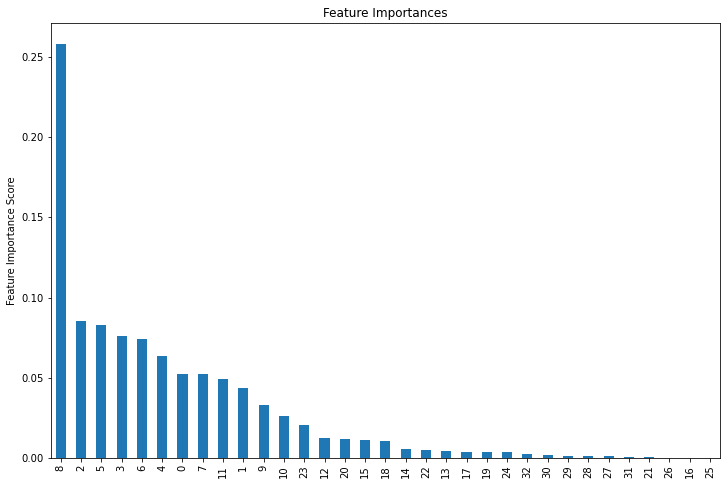

In [34]:
feat_imp = pd.Series(rf.feature_importances_).sort_values(ascending=False)
plt.figure(figsize=(12,8))
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [55]:
xg = xgb.XGBClassifier(objective='reg:logistic',
                       boosting_type='gbtree', 
                       learning_rate=0.01, 
                       n_estimators=5000, 
                       max_depth=8, 
                       base_score=0.7,
                       max_features='auto'
                     )

eval_set = [(x_train, y_train), (x_test, y_test)]
xg.fit(x_train, y_train, eval_metric="logloss", eval_set=eval_set, verbose=2, early_stopping_rounds = 80)

[21:07:36] WARNING: /workspace/src/learner.cc:480: 
Parameters: { boosting_type, max_features } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-logloss:1.02934	validation_1-logloss:1.02964
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 80 rounds.
[2]	validation_0-logloss:0.99976	validation_1-logloss:0.99952
[4]	validation_0-logloss:0.97084	validation_1-logloss:0.97138
[6]	validation_0-logloss:0.94412	validation_1-logloss:0.94479
[8]	validation_0-logloss:0.91951	validation_1-logloss:0.91963
[10]	validation_0-logloss:0.89532	validation_1-logloss:0.89599
[12]	validation_0-logloss:0.87326	validation_1-logloss:0.87348
[14]	validation_0-logloss:0.85184	validation

[242]	validation_0-logloss:0.27756	validation_1-logloss:0.28584
[244]	validation_0-logloss:0.27669	validation_1-logloss:0.28510
[246]	validation_0-logloss:0.27600	validation_1-logloss:0.28440
[248]	validation_0-logloss:0.27524	validation_1-logloss:0.28371
[250]	validation_0-logloss:0.27447	validation_1-logloss:0.28303
[252]	validation_0-logloss:0.27379	validation_1-logloss:0.28239


KeyboardInterrupt: 

In [17]:
pred = xg.predict(x_test)
pred

array([0.01095049, 0.00063961, 0.00334022, ..., 0.4377475 , 0.00824863,
       0.0017257 ], dtype=float32)

In [23]:
xg.feature_importances_

array([0.01472769, 0.00417481, 0.00686549, 0.        , 0.00359419,
       0.00525797, 0.00744865, 0.00366122, 0.17620459, 0.0033633 ,
       0.00393874, 0.21291384, 0.05019363, 0.04469667, 0.04809345,
       0.04519153, 0.01073598, 0.04333963, 0.0432976 , 0.04234079,
       0.04532566, 0.01489232, 0.04133054, 0.06576986, 0.03952994,
       0.00473798, 0.00227702, 0.00201783, 0.00363686, 0.0024629 ,
       0.00209837, 0.00189387, 0.00398702], dtype=float32)

Text(0, 0.5, 'Feature Importance Score')

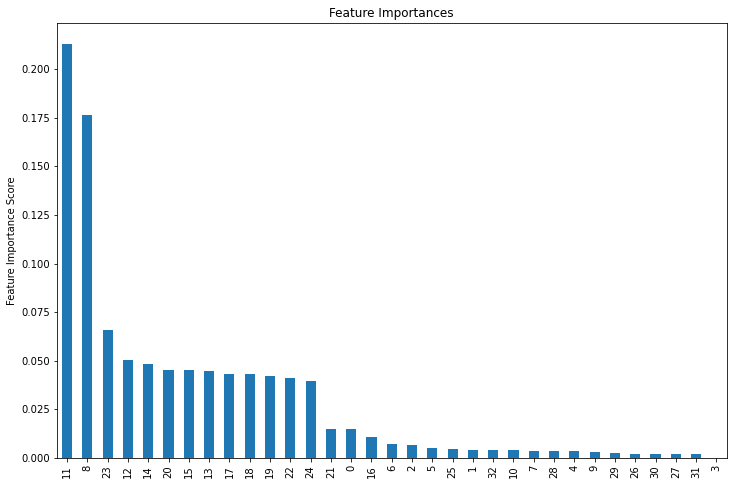

In [28]:
feat_imp = pd.Series(xg.feature_importances_).sort_values(ascending=False)
plt.figure(figsize=(12,8))
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [20]:
#preparing the predictions make into the sample file for submission

preds1 = xg.predict(test_enc)
sample1 = pd.read_csv('sample_submission.csv')
test = pd.read_csv('Test.csv')
sample1.user_id = test.user_id
sample1.CHURN = preds1
sample1.to_csv('XG.csv', index = False)

In [24]:
train1.head()

,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,REGULARITY,TOP_PACK,...,REGION_THIES,REGION_ZIGUINCHOR,TENURE_D 3-6 month,TENURE_E 6-9 month,TENURE_F 9-12 month,TENURE_G 12-15 month,TENURE_H 15-18 month,TENURE_I 18-21 month,TENURE_J 21-24 month,TENURE_K > 24 month
0,17000.0,32.0,18000.0,6000.0,34.0,-999.0,97.0,355.0,62,0.146687,...,0,0,0,0,0,0,0,0,0,1
1,4300.0,29.0,4427.0,1476.0,37.0,1764.0,8.0,3.0,40,0.038975,...,0,0,0,0,0,0,0,0,0,1
2,1500.0,3.0,1500.0,500.0,3.0,-999.0,30.0,30.0,32,0.146687,...,0,0,0,0,0,0,0,0,0,1
3,1500.0,3.0,2497.0,832.0,4.0,0.0,159.0,45.0,18,0.070968,...,0,0,0,0,0,0,0,0,0,1
4,-999.0,-999.0,498.0,166.0,3.0,1.0,1.0,3.0,50,0.418322,...,0,0,0,0,0,0,0,0,0,1


In [25]:
train1.columns

Index(['MONTANT', 'FREQUENCE_RECH', 'REVENUE', 'ARPU_SEGMENT', 'FREQUENCE',
       'DATA_VOLUME', 'ON_NET', 'ORANGE', 'REGULARITY', 'TOP_PACK',
       'FREQ_TOP_PACK', 'REGION_DAKAR', 'REGION_DIOURBEL', 'REGION_FATICK',
       'REGION_KAFFRINE', 'REGION_KAOLACK', 'REGION_KEDOUGOU', 'REGION_KOLDA',
       'REGION_LOUGA', 'REGION_MATAM', 'REGION_SAINT-LOUIS', 'REGION_SEDHIOU',
       'REGION_TAMBACOUNDA', 'REGION_THIES', 'REGION_ZIGUINCHOR',
       'TENURE_D 3-6 month', 'TENURE_E 6-9 month', 'TENURE_F 9-12 month',
       'TENURE_G 12-15 month', 'TENURE_H 15-18 month', 'TENURE_I 18-21 month',
       'TENURE_J 21-24 month', 'TENURE_K > 24 month'],
      dtype='object')

In [12]:
train1.dtypes

MONTANT                 float64
FREQUENCE_RECH          float64
REVENUE                 float64
ARPU_SEGMENT            float64
FREQUENCE               float64
DATA_VOLUME             float64
ON_NET                  float64
ORANGE                  float64
REGULARITY                int64
TOP_PACK                float64
FREQ_TOP_PACK           float64
REGION_DAKAR              uint8
REGION_DIOURBEL           uint8
REGION_FATICK             uint8
REGION_KAFFRINE           uint8
REGION_KAOLACK            uint8
REGION_KEDOUGOU           uint8
REGION_KOLDA              uint8
REGION_LOUGA              uint8
REGION_MATAM              uint8
REGION_SAINT-LOUIS        uint8
REGION_SEDHIOU            uint8
REGION_TAMBACOUNDA        uint8
REGION_THIES              uint8
REGION_ZIGUINCHOR         uint8
TENURE_D 3-6 month        uint8
TENURE_E 6-9 month        uint8
TENURE_F 9-12 month       uint8
TENURE_G 12-15 month      uint8
TENURE_H 15-18 month      uint8
TENURE_I 18-21 month      uint8
TENURE_J

In [54]:
sample1.CHURN

NameError: name 'sample1' is not defined